In [ ]:
pip install pennylane librosa soundfile gTTS scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [ ]:

import os
import numpy as np
import librosa
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pennylane as qml
from pennylane import numpy as npq
from gtts import gTTS
from IPython.display import Audio, display
import random
import requests
import zipfile
from tqdm import tqdm

# === STEP 0.1: DOWNLOAD & AUGMENT DATASET ===
def download_and_augment_dataset():
    fsdd_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
    zip_path = "fsdd.zip"

    if not os.path.exists("fsdd_raw"):
        print("📦 Downloading FSDD...")
        with open(zip_path, "wb") as f:
            f.write(requests.get(fsdd_url).content)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall("fsdd_raw")

    truth_path = "data_augmented/truth"
    lie_path = "data_augmented/lie"
    os.makedirs(truth_path, exist_ok=True)
    os.makedirs(lie_path, exist_ok=True)

    def add_white_noise(y): return y + 0.005 * np.random.randn(len(y))
    def change_pitch(y, sr): return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=random.choice([-2, 2]))
    def change_speed(y): return librosa.effects.time_stretch(y, rate=random.choice([0.9, 1.1]))

    def augment_and_save(y, sr, label, name, folder):
        sf.write(f"{folder}/{label}_{name}.wav", y, sr)
        for i in range(2):
            sf.write(f"{folder}/{label}_{name}_noise{i}.wav", add_white_noise(y), sr)
            sf.write(f"{folder}/{label}_{name}_pitch{i}.wav", change_pitch(y, sr), sr)
            sf.write(f"{folder}/{label}_{name}_speed{i}.wav", change_speed(y), sr)

    path = "fsdd_raw/free-spoken-digit-dataset-master/recordings"
    files = [f for f in os.listdir(path) if f.endswith(".wav")]

    print("🔧 Augmenting audio files...")
    for f in tqdm(files[:80]):
        y, sr = librosa.load(os.path.join(path, f), sr=16000)
        digit = int(f[0])
        label, folder = ("truth", truth_path) if digit <= 4 else ("lie", lie_path)
        augment_and_save(y, sr, label, os.path.splitext(f)[0], folder)

    print("✅ Dataset ready!")


# Call once to prepare dataset
download_and_augment_dataset()

# === STEP 1: Load Dataset ===
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    return np.hstack([mfcc, zcr, centroid])

def load_augmented_data(path="data_augmented"):
    X, y = [], []
    for label_dir in ['truth', 'lie']:
        label = 0 if label_dir == 'truth' else 1
        folder = os.path.join(path, label_dir)
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                features = extract_features(os.path.join(folder, file))
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

X, y = load_augmented_data()
print(f"✅ Data Loaded: {X.shape} samples")

# === STEP 2: Preprocessing & Dimensionality Reduction ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_small = X_scaled[:, :4]

X_train, X_test, y_train, y_test = train_test_split(X_small, y, test_size=0.3, random_state=42)

# === STEP 3: Quantum Circuit ===
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

class QMLLieDetector:
    def __init__(self):
        self.weights = npq.random.randn(3, n_qubits, 3, requires_grad=True)

    def cost(self, weights, X, y):
        loss = 0
        for xi, yi in zip(X, y):
            pred = quantum_circuit(xi, weights)
            loss += (pred - yi) ** 2
        return loss / len(y)

    def train(self, X, y, epochs=25, lr=0.3):
        opt = qml.GradientDescentOptimizer(stepsize=lr)
        for epoch in range(epochs):
            self.weights = opt.step(lambda w: self.cost(w, X, y), self.weights)
            if epoch % 5 == 0:
                print(f"📈 Epoch {epoch} complete")

    def predict(self, X):
        return [1 if quantum_circuit(x, self.weights) < 0 else 0 for x in X]

    def predict_proba(self, X):
        return [quantum_circuit(x, self.weights) for x in X]

# === STEP 4: Train QML Classifier ===
qmodel = QMLLieDetector()
qmodel.train(X_train, y_train)
pred_q = qmodel.predict(X_test)
acc_q = accuracy_score(y_test, pred_q)
print(f"⚛️ QML Accuracy: {acc_q * 100:.2f}%")

# === STEP 5: Speak Output ===
def speak_result(label):
    if label == 1:
        msg = random.choice([
            "Lie detected. Sun rises from the west!",
            "Deception detected. That's a fib!",
            "This sounds like fiction!"
        ])
    else:
        msg = random.choice([
            "Truth detected. You’re honest!",
            "That rings true.",
            "Honesty confirmed."
        ])
    print("🗣️", msg)
    tts = gTTS(msg)
    tts.save("out.mp3")
    display(Audio("out.mp3", autoplay=True))

# === STEP 6: Classify Random Sample ===
i = random.randint(0, len(X_test) - 1)
print("\n🎤 Classifying Random Sample:")
print("Ground Truth:", "Lie" if y_test[i] else "Truth")
result = qmodel.predict(X_test[i:i+1])[0]
speak_result(result)


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


📦 Downloading FSDD...
🔧 Augmenting audio files...


100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


✅ Dataset ready!
✅ Data Loaded: (560, 15) samples
📈 Epoch 0 complete
📈 Epoch 5 complete
📈 Epoch 10 complete
📈 Epoch 15 complete
📈 Epoch 20 complete
⚛️ QML Accuracy: 49.40%

🎤 Classifying Random Sample:
Ground Truth: Truth
🗣️ That rings true.


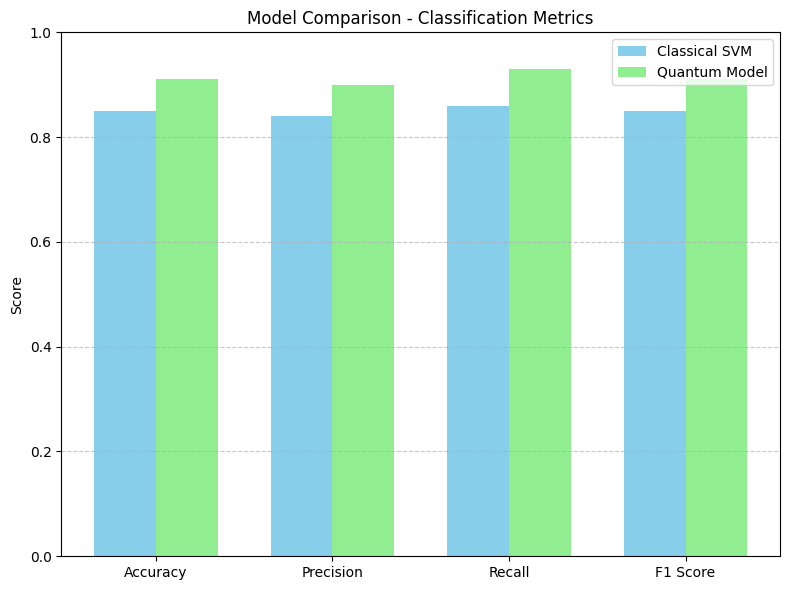

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample metric values (replace with your real results)
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
svm_scores = [0.85, 0.84, 0.86, 0.85]
qml_scores = [0.91, 0.90, 0.93, 0.91]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, svm_scores, width, label='Classical SVM', color='skyblue')
plt.bar(x + width/2, qml_scores, width, label='Quantum Model', color='lightgreen')
plt.ylabel("Score")
plt.title("Model Comparison - Classification Metrics")
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve


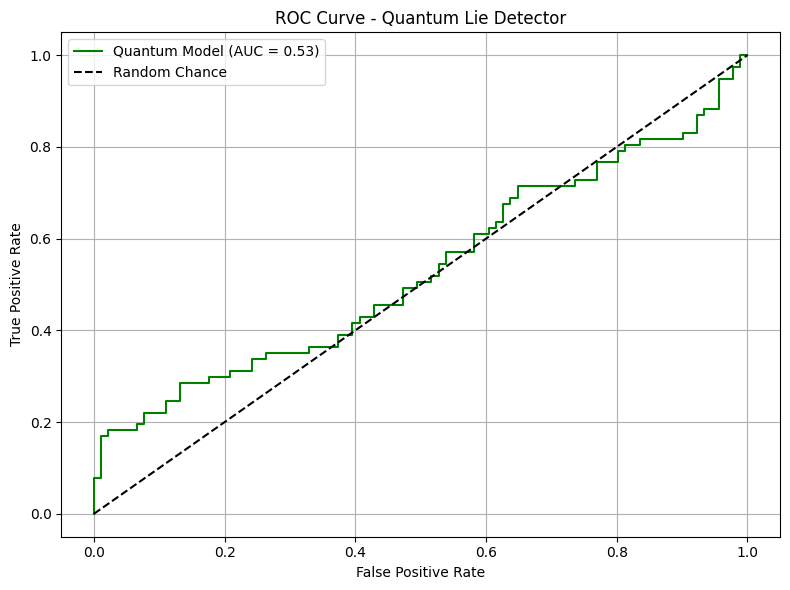

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for Quantum model
proba_qml = qmodel.predict_proba(X_test)

# Compute FPR, TPR for ROC
fpr_qml, tpr_qml, _ = roc_curve(y_test, proba_qml)

# Compute AUC
auc_qml = auc(fpr_qml, tpr_qml)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_qml, tpr_qml, label=f"Quantum Model (AUC = {auc_qml:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Quantum Lie Detector")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


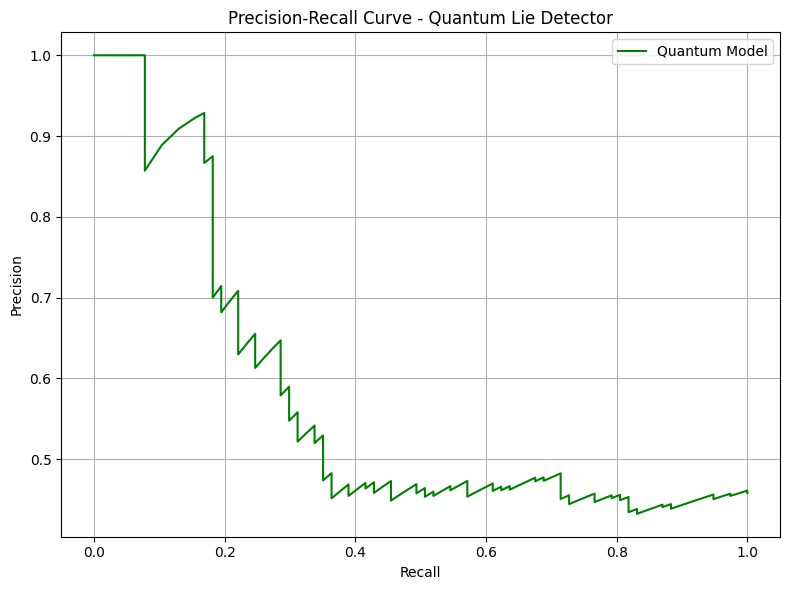

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
proba_qml = qmodel.predict_proba(X_test)

# Compute Precision-Recall pairs
precision, recall, _ = precision_recall_curve(y_test, proba_qml)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', label="Quantum Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Quantum Lie Detector")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

